In [2]:
import sys

sys.path.append("../")
sys.path.append("../../blackjax")



from benchmarks.inference_models import Brownian
from benchmarks.sampling_algorithms import adjusted_mclmc, adjusted_mclmc_tuning, nuts
from blackjax.diagnostics import effective_sample_size
from collections import defaultdict
from functools import partial
import math
import operator
import os
import pprint
from statistics import mean, median
import jax
import jax.numpy as jnp
import pandas as pd
import scipy
from jax.flatten_util import ravel_pytree
from benchmarks.benchmark import benchmark
from benchmarks.sampling_algorithms import unadjusted_mclmc
from benchmarks.inference_models import Gaussian, Brownian, GermanCredit
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import seaborn as sns
from blackjax.adaptation.mclmc_adaptation import MCLMCAdaptationState
import blackjax 

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=" + str(128)
num_cores = jax.local_device_count()

# model = StandardNormal(10)
# model = IllConditionedGaussian(100, 12916)

def run_benchmark(model, num_steps, num_chains=128, desired_energy_var=5e-4):

    results = defaultdict(tuple)


    integrator_type = "mclachlan"

    preconditioning = False


    init_key, mclmc_key, nuts_key = jax.random.split(jax.random.PRNGKey(2), 3)
    initial_position = model.sample_init(init_key)
    

   
    ess, ess_avg, ess_corr, params, acceptance_rate, grads_to_low_avg, err_t_mean_avg_mclmc, err_t_mean_max_mclmc = benchmark(
                model,
                unadjusted_mclmc(integrator_type=integrator_type, preconditioning=preconditioning, desired_energy_var=desired_energy_var),
                mclmc_key,
                n=num_steps,
                batch=num_chains,
    )

    

 
    
    # ess, ess_avg, ess_corr, params, acceptance_rate, grads_to_low_avg, err_t_mean_avg_adjusted_mclmc, err_t_mean_max_adjusted_mclmc = benchmark(
    #     model=model,
    #     sampler=adjusted_mclmc(integrator_type=integrator_type, preconditioning=False, num_windows=1,max='max', frac_tune3=0.0, tuning_factor=1.3,target_acc_rate=0.9, L_proposal_factor=jnp.inf, random_trajectory_length=True),
    #     key=jax.random.PRNGKey(1), 
    #     n=num_steps,
    #     batch=num_chains,  
    # )

    
    
    
    # ess, ess_avg, ess_corr, params, acceptance_rate, grads_to_low_avg, err_t_mean_avg_nuts, err_t_mean_max_nuts = benchmark(
    #                 model,
    #                 nuts(integrator_type="velocity_verlet", preconditioning=preconditioning),
    #                 nuts_key,
    #                 n=num_steps/100,
    #                 batch=num_chains,
    #             )
                


   
    # return err_t_mean_avg_mclmc, err_t_mean_max_mclmc, err_t_mean_avg_nuts, err_t_mean_max_nuts, err_t_mean_avg_adjusted_mclmc, err_t_mean_max_adjusted_mclmc
    # return err_t_mean_avg_mclmc, err_t_mean_max_mclmc, err_t_mean_avg_adjusted_mclmc, err_t_mean_max_adjusted_mclmc
    return err_t_mean_avg_mclmc, err_t_mean_max_mclmc

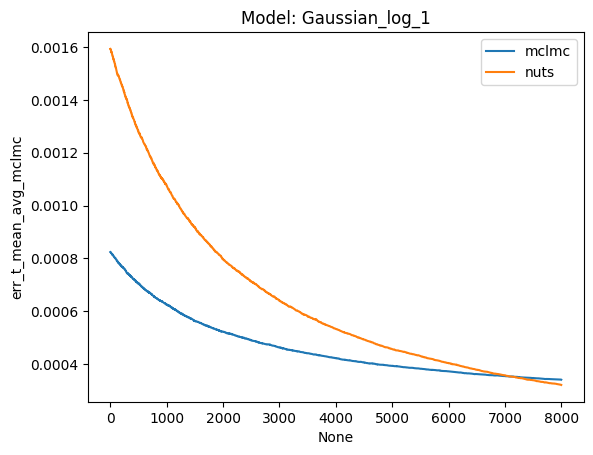

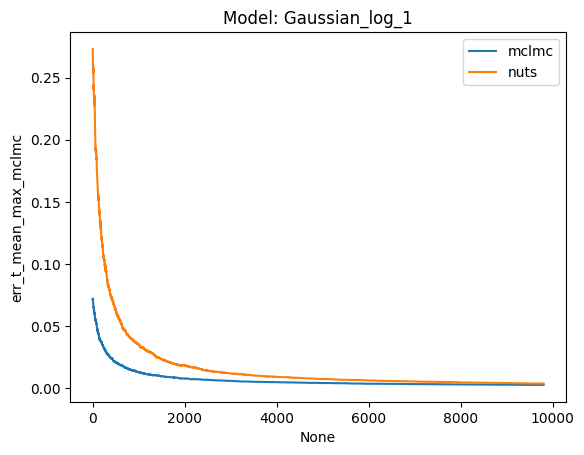

In [7]:
plot_bias(Gaussian(1000), num_steps=10000)
# plot_bias(Gaussian(10))
# plot_bias(GermanCredit())
# plot_bias(Gaussian(1000))

NUTS


END NUTS


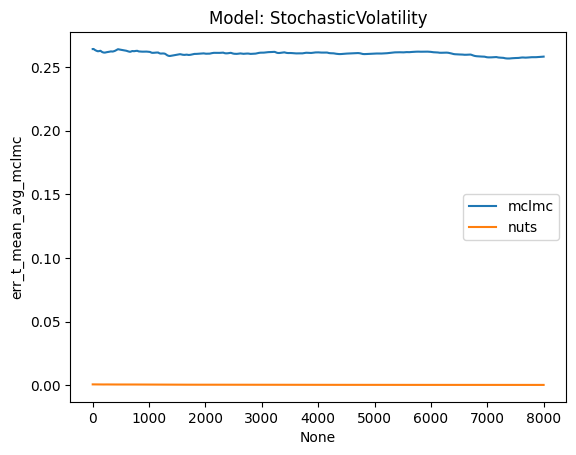

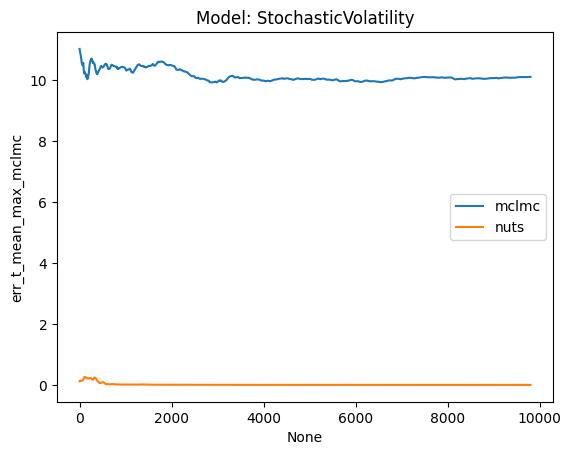

In [3]:

from benchmarks.inference_models import StochasticVolatility


plot_bias(StochasticVolatility(), num_steps=10000, num_chains=10)

In [8]:
from benchmarks.inference_models import Funnel




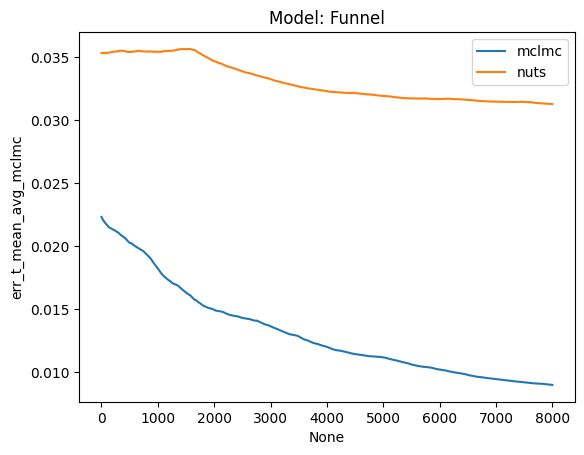

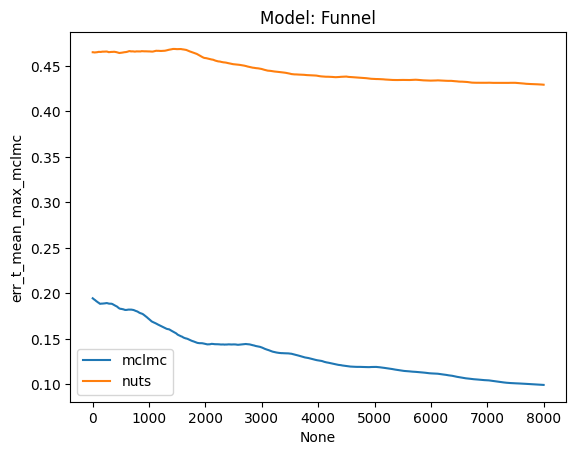

In [9]:
plot_bias(Funnel(), err_t_mean_avg_mclmc, err_t_mean_max_mclmc, err_t_mean_avg_nuts, err_t_mean_max_nuts)

In [5]:
def plot_bias(model, err_t_mean_avg_mclmc, err_t_mean_max_mclmc, burn_in=2000):


    df_err = pd.DataFrame({'err_t_mean_avg_mclmc': err_t_mean_avg_mclmc[burn_in:]})
    # df_err['sampler'] = 'mclmc'
    # df_err_nuts['sampler'] = 'nuts'
    # df = pd.concat([df_err_mclmc, df_err_nuts])
    df_err
    sns.lineplot(data=df_err, x=df_err.index, y='err_t_mean_avg_mclmc', label='mclmc')
    plt.title(f"Model: {model.name}")
    plt.show()

    df_err = pd.DataFrame({'err_t_mean_max_mclmc': err_t_mean_max_mclmc[burn_in:]})
    # df_err['sampler'] = 'mclmc'
    # df_err_nuts['sampler'] = 'nuts'
    # df = pd.concat([df_err_mclmc, df_err_nuts])
    df_err
    sns.lineplot(data=df_err, x=df_err.index, y='err_t_mean_max_mclmc', label='mclmc')
    plt.title(f"Model: {model.name}")
    plt.show()



In [3]:
from benchmarks.inference_models import (
    StochasticVolatility
)

err_t_mean_avg_mclmc, err_t_mean_max_mclmc = run_benchmark(StochasticVolatility(), num_steps=10000, num_chains=10, desired_energy_var=5e-5)



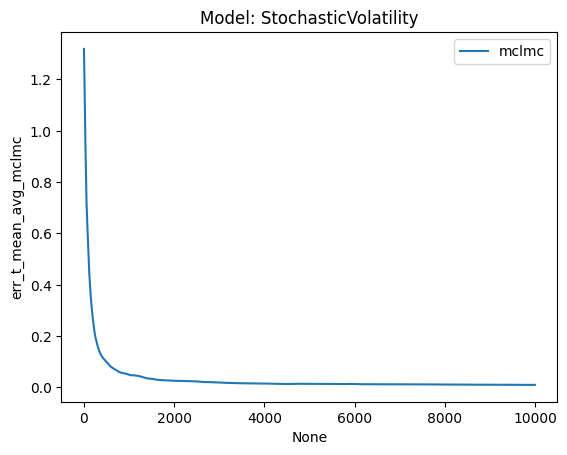

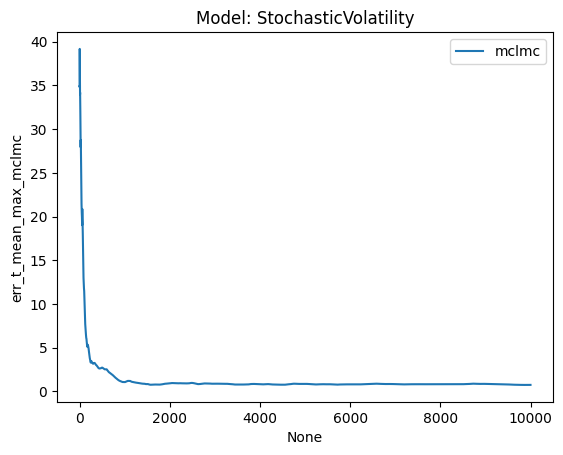

In [6]:
plot_bias(StochasticVolatility(), err_t_mean_avg_mclmc, err_t_mean_max_mclmc, burn_in=0)

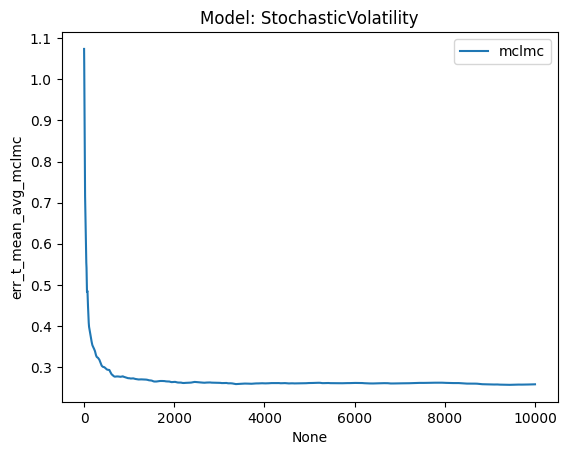

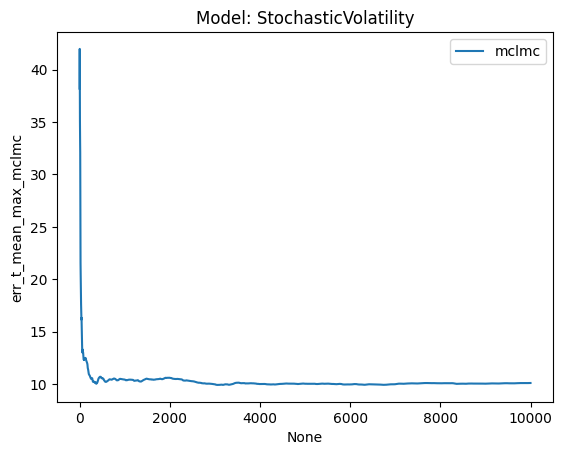

In [12]:
# calculate_ess(
#         err_t_mean_max_nuts, 
#         grad_evals_per_step=avg_grad_calls_per_traj,
#         num_tuning_steps=num_tuning_steps
#     )

plot_bias(StochasticVolatility(), err_t_mean_avg_mclmc, err_t_mean_max_mclmc, burn_in=0)

In [35]:
def run_mclmc(logdensity_fn, num_steps, initial_position, key, transform, desired_energy_variance= 5e-4):
    init_key, tune_key, run_key = jax.random.split(key, 3)

    # create an initial state for the sampler
    initial_state = blackjax.mcmc.mclmc.init(
        position=initial_position, logdensity_fn=logdensity_fn, rng_key=init_key
    )

    # build the kernel
    kernel = lambda sqrt_diag_cov : blackjax.mcmc.mclmc.build_kernel(
        logdensity_fn=logdensity_fn,
        integrator=blackjax.mcmc.integrators.isokinetic_mclachlan,
        sqrt_diag_cov=sqrt_diag_cov,
    )

    # find values for L and step_size
    (
        blackjax_state_after_tuning,
        blackjax_mclmc_sampler_params,
    ) = blackjax.mclmc_find_L_and_step_size(
        mclmc_kernel=kernel,
        num_steps=num_steps,
        state=initial_state,
        rng_key=tune_key,
        diagonal_preconditioning=False,
        desired_energy_var=desired_energy_variance
    )

    # use the quick wrapper to build a new kernel with the tuned parameters
    sampling_alg = blackjax.mclmc(
        logdensity_fn,
        # L=blackjax_mclmc_sampler_params.L,
        # step_size=blackjax_mclmc_sampler_params.step_size,
        #  TODO correct
        L=jnp.sqrt(initial_position.shape[0]),
        step_size=5,
    )

    # run the sampler
    _, samples = blackjax.util.run_inference_algorithm(
        rng_key=run_key,
        initial_state=blackjax_state_after_tuning,
        inference_algorithm=sampling_alg,
        num_steps=num_steps,
        transform=transform,
        progress_bar=True,
    )

    return samples, blackjax_state_after_tuning, blackjax_mclmc_sampler_params, run_key

from blackjax.mcmc.integrators import (

    isokinetic_velocity_verlet,
    isokinetic_yoshida,
    isokinetic_omelyan,
)
from blackjax.util import run_inference_algorithm
from blackjax.mcmc.adjusted_mclmc import rescale

def run_adjusted_mclmc(logdensity_fn, num_steps, initial_position, key, transform):
    init_key, tune_key, run_key = jax.random.split(key, 3)


    # num_steps_per_traj = L / step_size

    integration_steps_fn = lambda avg_num_integration_steps: lambda k: jnp.ceil(
            jax.random.uniform(k) * rescale(avg_num_integration_steps))

    kernel = lambda rng_key, state, avg_num_integration_steps, step_size, sqrt_diag_cov: blackjax.mcmc.adjusted_mclmc.build_kernel(
        integrator=isokinetic_velocity_verlet,
        integration_steps_fn=integration_steps_fn(avg_num_integration_steps),
        sqrt_diag_cov=sqrt_diag_cov,
        )(
            rng_key=rng_key,
            state=state,
            step_size=step_size,
            logdensity_fn=logdensity_fn,
            L_proposal_factor=jnp.inf,
        )


    target_acc_rate = 0.65



    initial_state = blackjax.mcmc.adjusted_mclmc.init(
        position=initial_position,
        logdensity_fn=logdensity_fn,
        random_generator_arg=init_key,
    )

    

    

    logdensity_grad_fn = jax.grad(logdensity_fn)

    (
        blackjax_state_after_tuning,
        blackjax_mclmc_sampler_params,
        
    ) = blackjax.adjusted_mclmc_find_L_and_step_size(
        mclmc_kernel=kernel,
        num_steps=num_steps,
        state=initial_state,
        rng_key=tune_key,
        target=target_acc_rate,
        frac_tune1=0.1,
        frac_tune2=0.1,
        frac_tune3=0.1,
        diagonal_preconditioning=False,
        params=None,
        max='max',
        num_windows=1,
        tuning_factor=1.3,
        logdensity_grad_fn=logdensity_grad_fn,
    )

    #  TODO correct this
    L=jnp.sqrt(initial_position.shape[0])
    step_size=5
    

    num_steps_per_traj = blackjax_mclmc_sampler_params.L / blackjax_mclmc_sampler_params.step_size
    integration_steps_fn = lambda k: jnp.ceil(jax.random.uniform(k) * rescale(num_steps_per_traj))
    
    alg = blackjax.adjusted_mclmc(
        logdensity_fn=logdensity_fn,
        step_size=blackjax_mclmc_sampler_params.step_size,
        integration_steps_fn=integration_steps_fn,
        integrator= isokinetic_velocity_verlet,
        sqrt_diag_cov=1.0,
        L_proposal_factor=jnp.inf,
    )

    return run_inference_algorithm(
        rng_key=key,
        initial_state=blackjax_state_after_tuning,
        inference_algorithm=alg,
        num_steps=num_steps,
        transform=transform,
        progress_bar=False,
    )[1]



In [41]:
model = Gaussian(100)
initial_position = model.sample_init(jax.random.PRNGKey(0))

adjusted_samples = run_adjusted_mclmc(
    logdensity_fn=model.logdensity_fn, 
    num_steps=1000000, 
    initial_position=initial_position, 
    key=jax.random.PRNGKey(0),
    transform=lambda x, _: x.position
)

(10000, 10)

In [42]:
model = Gaussian(100)
initial_position = model.sample_init(jax.random.PRNGKey(0))

unadjusted_samples, _, _, _ = run_mclmc(
    logdensity_fn=Gaussian(100).logdensity_fn, 
    num_steps=1000000, 
    initial_position=initial_position, 
    key=jax.random.PRNGKey(0),
    transform=lambda x, _: x.position
)

In [26]:
samples.shape

(10000, 100)

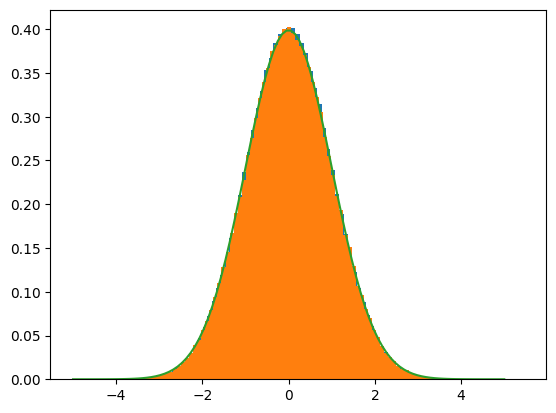

In [43]:
unadjusted_samples_1D = unadjusted_samples[:, 0]
adjusted_samples_1D = adjusted_samples[:, 0]
# make histogram of samples_1D
plt.hist(unadjusted_samples_1D, bins=100, density=True)
plt.hist(adjusted_samples_1D, bins=100, density=True)
# plot normal log density over this
x = jnp.linspace(-5, 5, 100)
plt.plot(x, jax.scipy.stats.norm.pdf(x, loc=0, scale=1))
plt.show()